In [66]:
import tempfile
import numpy as np

In [67]:
def midplane_velocity_profile(ax, pos, u, h, marker, color):
    size = 10 
    y_min = min(pos[1])
    y_max = max(pos[1])
    midpoint = (y_max - y_min)/2
    xs = pos[0]
    ys = pos[1]
    midplane = [i for i, (_, y) in enumerate(zip(xs, ys)) if abs(y - midpoint) < h]
    xs_midplane = [xs[i] for i in midplane]
    uy_midplane = [u[1][i] for i in midplane]
    ax.scatter(xs_midplane, uy_midplane, s=size, color=color, marker=marker, facecolors='none')
    ax.set_xlabel('$p_x$')
    ax.set_ylabel('$u_y$')
    ax.set_title('Cross section velocity profiles')

# Execute all versions of lid driven cavity problem

In [68]:
from pathlib import Path
from xml.etree import ElementTree
path = "bin"
programs = {
    "Lid driven cavity": ("SparseLUWrapper", "SparseLUWrapper"),
    "Lid driven cavity QR GPU": ("QR", "SparseLUWrapper"),
    # "Lid driven cavity iterative GPU" : "lidDrivenIterativeGPU" # useless...
    "Lid driven cavity GPU with DSS" : ("DSS", "SparseLUWrapper"),
    "Lid driven cavity GPU with DSS and RF" : ("DSS", "RF")
}
hs = [h/1000.0 for h in range(20, 2, -2)]
param_directory = tempfile.TemporaryDirectory()

Create parameter files

In [69]:
def get_output_path(program, h):
    return Path("benchmark", f"lidDriven_{program}_{int(h*1000):0>2}_result.h5")
def get_param_path(param_dir, program, h):
    return Path(param_dir.name, f"chanelFlow_{program}_{int(h*1000):0>2}.xml")

In [70]:
parameter_path = Path("..", "params")
default_param = parameter_path / "chanelFlow.xml"
for name, (solver_u, solver_p) in programs.items():
    params_tree = ElementTree.parse(default_param)
    root = params_tree.getroot()
    for h in hs:
        num_xml = root.find("./num")
        num_xml.set('h', str(h))
        case_xml = root.find("./case")
        case_xml.set('solver_u', solver_u)
        case_xml.set('solver_p', solver_p)
        output = root.find("./output")
        output.set("hdf5_name", str(Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)))
        param_output_path = get_param_path(param_directory, f"{solver_u}_{solver_p}", h)
        params_tree.write(param_output_path)

Run program for every parameter file

In [71]:
import subprocess
from concurrent.futures.process import ProcessPoolExecutor
def run_lid_driven(param_file):
    subprocess.run(["../bin/lidDriven", param_file])
parameter_dir = Path("..", "params", "benchmark")
to_run = []
for param_file in Path(param_directory.name).glob("*.xml"):
    params_tree = ElementTree.parse(param_file)
    root = params_tree.getroot()
    output_xml = root.find("./output")
    output_path = Path(output_xml.get("hdf5_name"))
    if Path.exists(output_path):
        continue
    to_run.append(param_file)
with ProcessPoolExecutor(4) as pool:
    pool.map(run_lid_driven, to_run)


Display benchmarking results

In [72]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

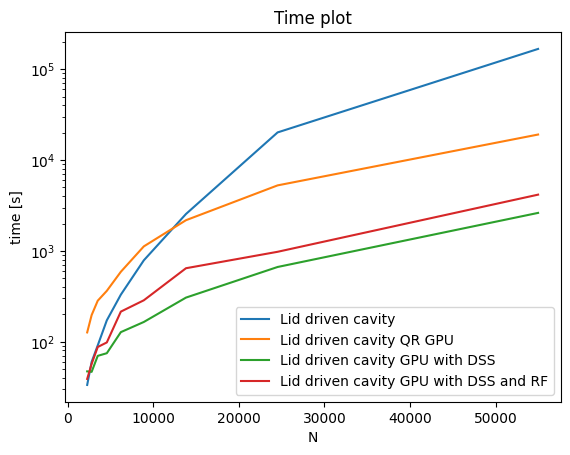

In [73]:
fig, ax = plt.subplots()
for name, (solver_u, solver_p) in programs.items():
    ts = []
    Ns = []
    for h in hs:
        result_file = Path("..") / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            time = f.attrs["time"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
plt.yscale('log')
ax.set_title("Time plot")
ax.legend()

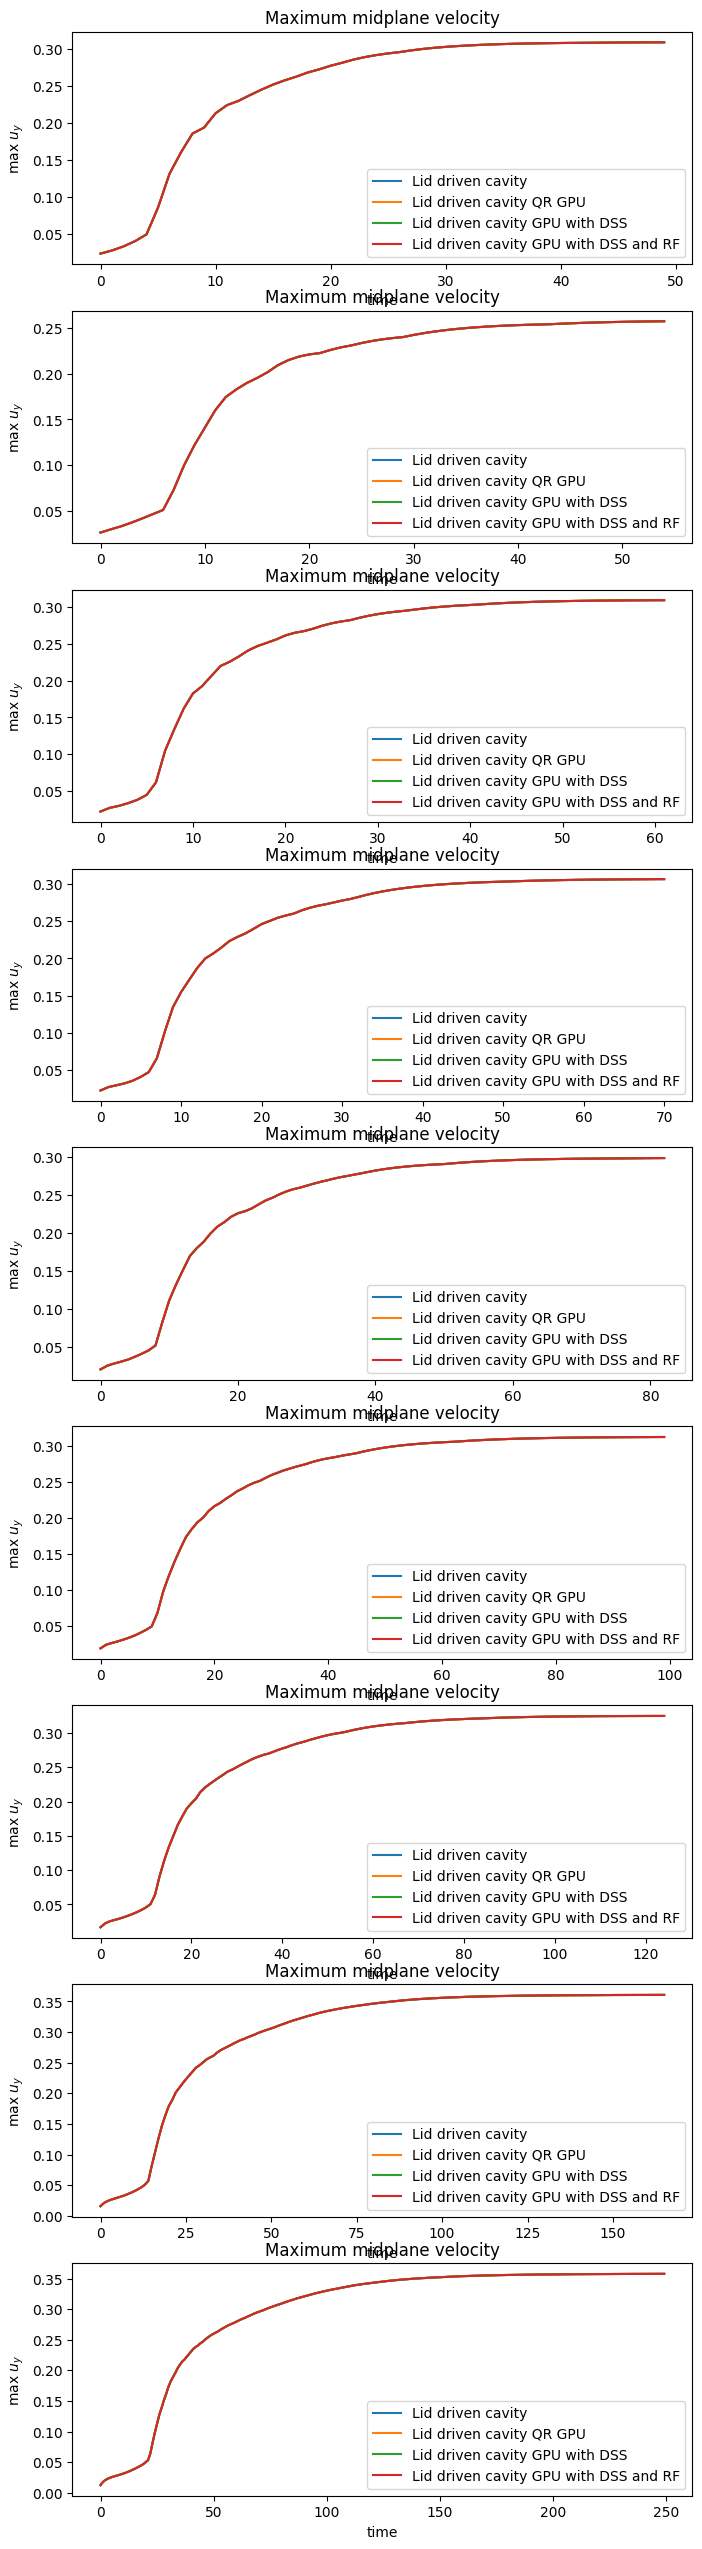

In [74]:
fig, axs = plt.subplots(len(hs), figsize=(8,32))
for i, h in enumerate(hs):
    for name, (solver_u, solver_p) in programs.items():
        result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            velocity = np.array(f['max_u_y'], dtype=np.float64)
            xs = list(range(len(velocity[0])))
            axs[i].plot(xs, velocity[0], label=name)
            axs[i].set_title('Maximum midplane velocity')
            axs[i].set_xlabel('time')
            axs[i].set_ylabel('max $u_y$')
            axs[i].legend()

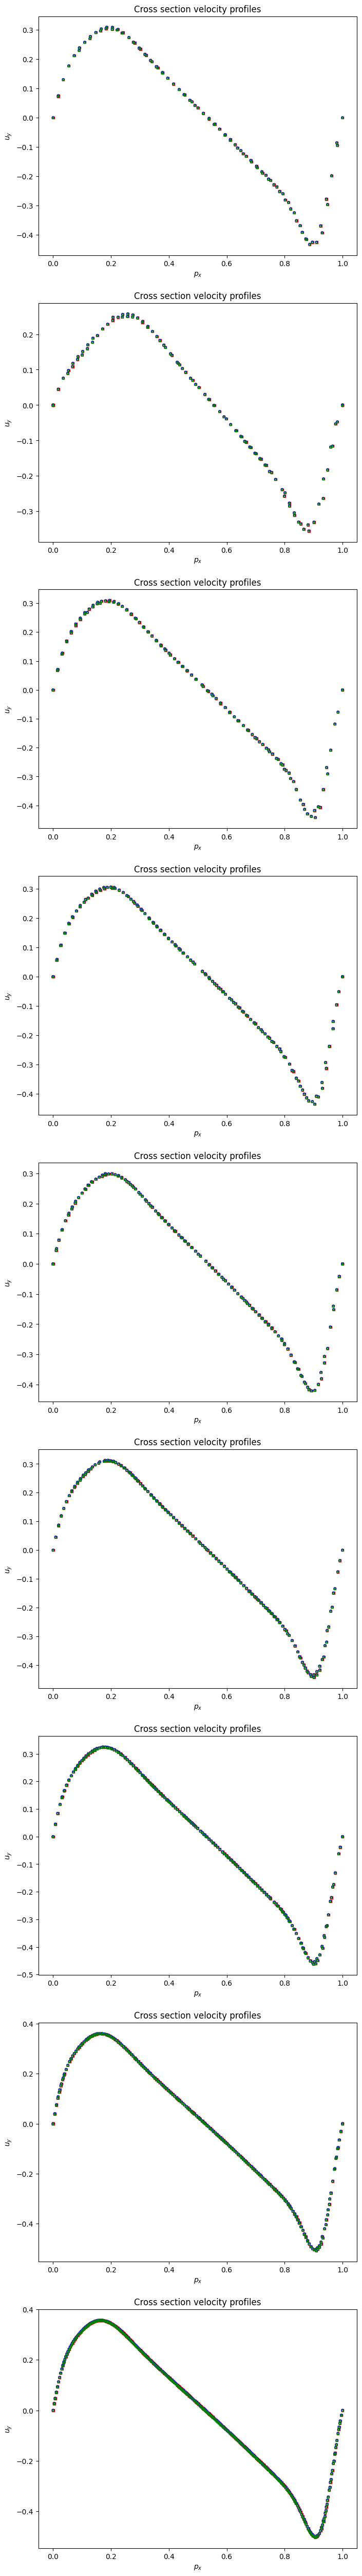

In [75]:
fig, axs = plt.subplots(len(hs), figsize=(8,64))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['s', 'o', '^', '+', 'D']
for i, h in enumerate(hs):
    for j, (name, (solver_u, solver_p)) in enumerate(programs.items()):
        result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            u = np.array(f['velocity'], dtype=np.float64)
            pos = np.array(f['domain/pos'], dtype=np.float64)
            midplane_velocity_profile(axs[i], pos, u, h, markers[j], colors[j])

In [76]:
programs_acm = {
    # "Lid driven cavity ACM": "lidDrivenACM",
    "Lid driven cavity matrix ACM": "lidDrivenMatrixACM",
    "Lid driven cavity matrix GPU ACM": "lidDrivenMatrixACMGPU"
}
hs_acm = [h / 1000.0 for h in range(20, 0, -2)]
acm_parameter_dir = tempfile.TemporaryDirectory()

In [77]:
parameter_path = Path("..", "params")
default_param = parameter_path / "chanelFlowACM.xml"
for name, program in programs_acm.items():
    params_tree = ElementTree.parse(default_param)
    root = params_tree.getroot()
    for h in hs_acm:
        num_xml = root.find("./num")
        num_xml.set('h', str(h))
        output = root.find("./output")
        output.set("hdf5_name", str(Path('..') / get_output_path(program, h)))
        case_xml = root.find("./case")
        case_xml.set('program', program)
        param_output_path = get_param_path(acm_parameter_dir, program, h)
        params_tree.write(param_output_path)

In [78]:
import subprocess
import os
from concurrent.futures.process import ProcessPoolExecutor
def run_lid_driven_acm(program, param_file):
    subprocess.run([f"../bin/{program}", param_file])
parameter_dir = Path("..", "params", "benchmark")
to_run = []
to_run_programs = []
for param_file in Path(acm_parameter_dir.name).glob("*.xml"):
    params_tree = ElementTree.parse(param_file)
    root = params_tree.getroot()
    output_xml = root.find("./output")
    output_path = Path(output_xml.get("hdf5_name"))
    if Path.exists(output_path):
        print(f"Skipping: {output_path}")
        continue
    print(f"Executing {output_path}")
    case_xml = root.find("./case")
    program = case_xml.get("program")
    # to_run.append((program, param_file))
    to_run_programs.append(program)
    to_run.append(param_file)
print(to_run)
# with ProcessPoolExecutor(1) as pool:
    # pool.map(run_lid_driven_acm, to_run_programs, to_run)
list(map(run_lid_driven_acm, to_run_programs, to_run))


Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_06_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_14_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_18_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_08_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_20_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_06_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_12_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_02_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_04_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_08_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_12_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_16_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_10_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_02_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_04_result.h5
S

[]

../benchmark/lidDriven_lidDrivenMatrixACM_20_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_18_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_16_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_14_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_12_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_10_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_08_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_06_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_04_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_02_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_20_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_18_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_16_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_14_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_12_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_10_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_08_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU

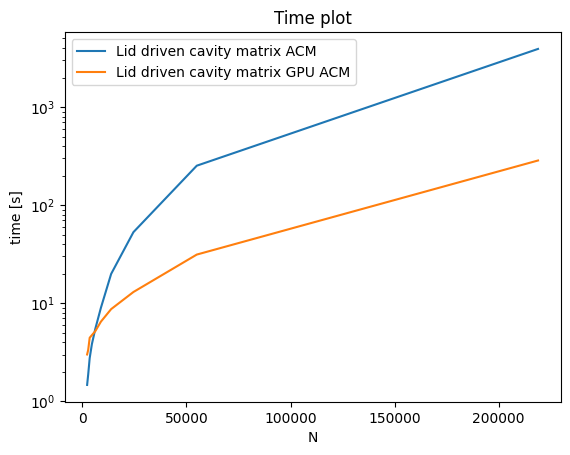

In [79]:
fig, ax = plt.subplots()
for name, program in programs_acm.items():
    ts = []
    Ns = []
    for h in hs_acm:
        result_file = Path("..") / get_output_path(program, h)
        print(result_file)
        with h5py.File(result_file) as f:
            time = f.attrs["time"] - f.attrs["setup"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
            # print(name)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
plt.yscale('log')
ax.set_title("Time plot")
ax.legend()

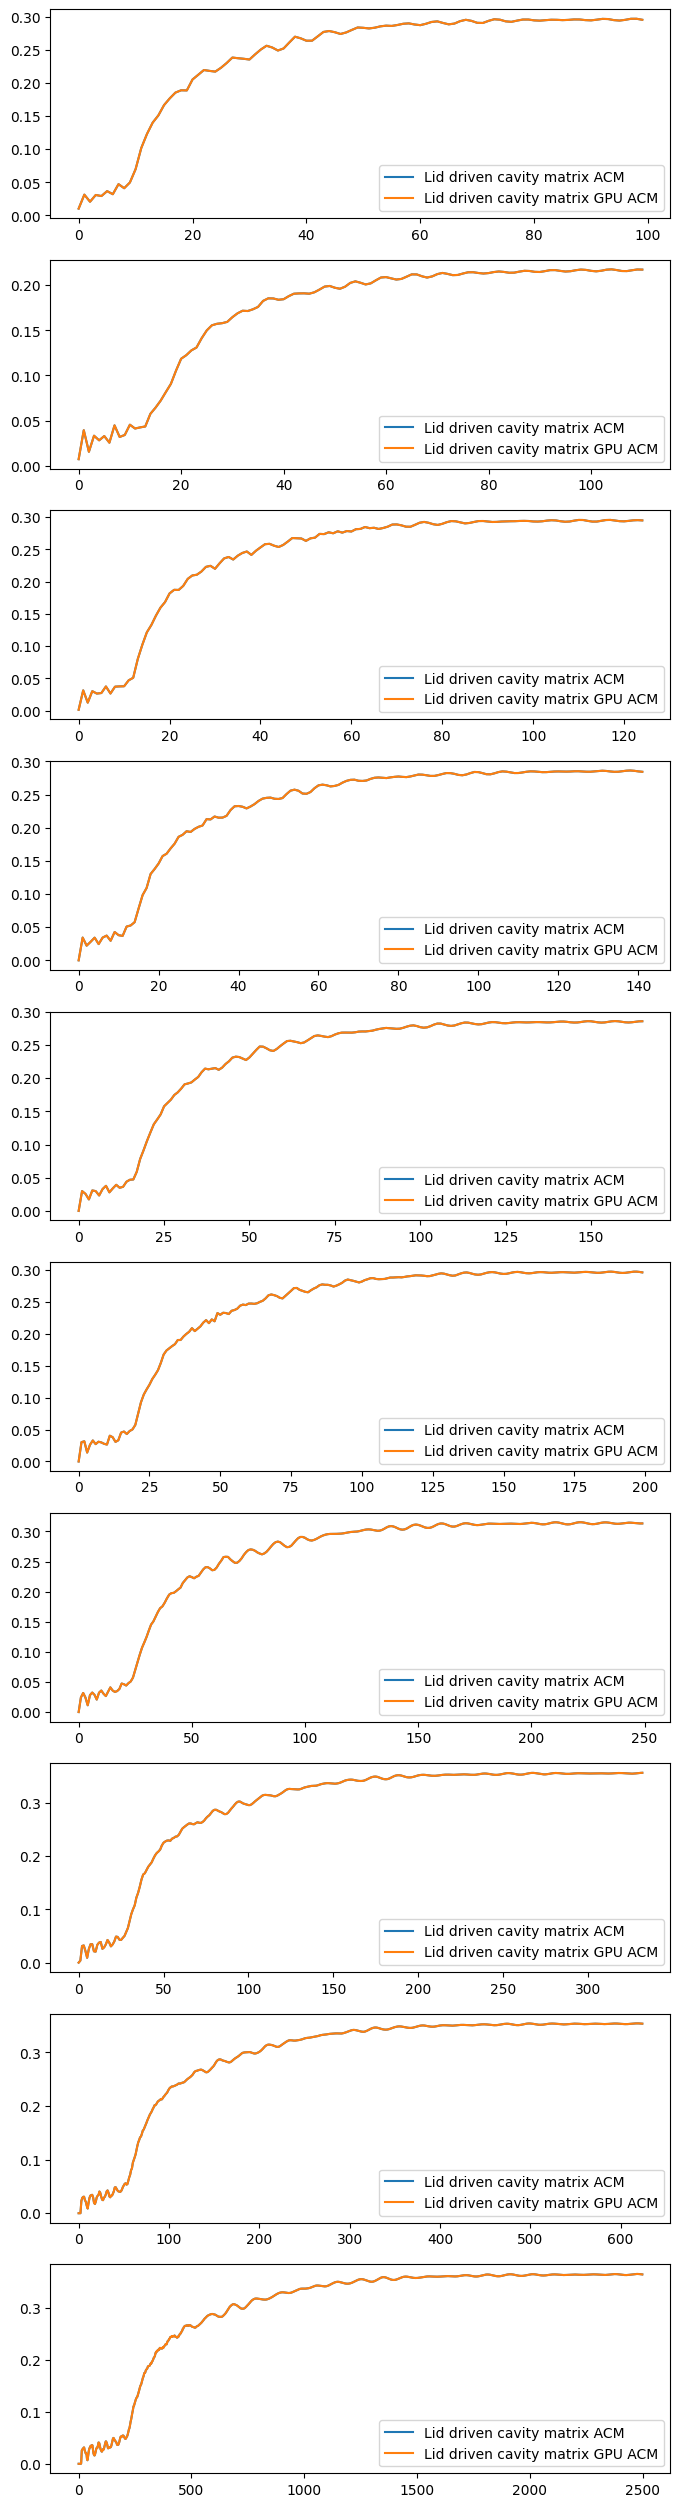

In [80]:
fig, axs = plt.subplots(len(hs_acm), figsize=(8,32))
for i, h in enumerate(hs_acm):
    for name, program in programs_acm.items():
        result_file = Path('..') / get_output_path(program, h)
        with h5py.File(result_file) as f:
            velocity = np.array(f['max_u_y'], dtype=np.float64)
            xs = list(range(len(velocity[0])))
            axs[i].plot(xs, velocity[0], label=name)
            axs[i].legend()

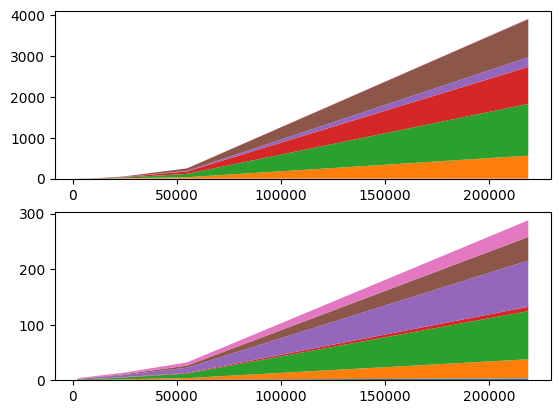

In [81]:
fig, ax = plt.subplots(2)
times = ["setup", "u = u + dt / Re * lap * u", "derivative stack correction", "PV correction", "max_norm", "p", "max_div", "print"]
for i, (name, program) in enumerate(programs_acm.items()):
    ts = {} 
    for time_name in times:
        ts[time_name] = []
    Ns = []
    for h in hs_acm:
        result_file = Path("..") / get_output_path(program, h)
        with h5py.File(result_file) as f:
            # time = f.attrs["time"] - f.attrs["setup"]
            for time_name in times:
                ts[time_name].append(f.attrs[time_name])
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
    ax[i].stackplot(Ns, np.vstack(tuple(ts.values())))
    # ax[i].set_yscale("log")

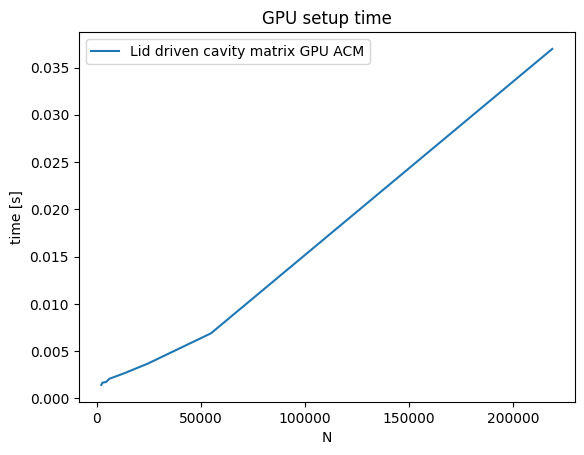

In [82]:
fig, ax = plt.subplots()
for name, program in programs_acm.items():
    if program == "lidDrivenMatrixACM":
        continue
    ts = []
    Ns = []
    for h in hs_acm:
        result_file = Path("..") / get_output_path(program, h)
        with h5py.File(result_file) as f:
            time = f.attrs["gpu setup"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
# plt.yscale('log')
ax.set_title("GPU setup time")
ax.legend()

[[ 0.          1.          0.         ... -0.06285001 -0.0804087
  -0.06861365]
 [ 0.          0.          0.         ...  0.01365487  0.00853939
   0.03774508]]
[[ 0.          1.          0.         ... -0.06285001 -0.0804087
  -0.06861365]
 [ 0.          0.          0.         ...  0.01365487  0.00853939
   0.03774508]]
[[ 0.          1.          0.         ... -0.05624404 -0.05743999
  -0.06219048]
 [ 0.          0.          0.         ...  0.05283842  0.03751938
   0.0230354 ]]
[[ 0.          1.          0.         ... -0.05624404 -0.05743999
  -0.06219048]
 [ 0.          0.          0.         ...  0.05283842  0.03751938
   0.0230354 ]]
[[ 0.          1.          0.         ... -0.04738428 -0.06165882
  -0.05969317]
 [ 0.          0.          0.         ...  0.01637574  0.01140545
   0.03318175]]
[[ 0.          1.          0.         ... -0.04738428 -0.06165882
  -0.05969317]
 [ 0.          0.          0.         ...  0.01637574  0.01140545
   0.03318175]]
[[ 0.          1.       

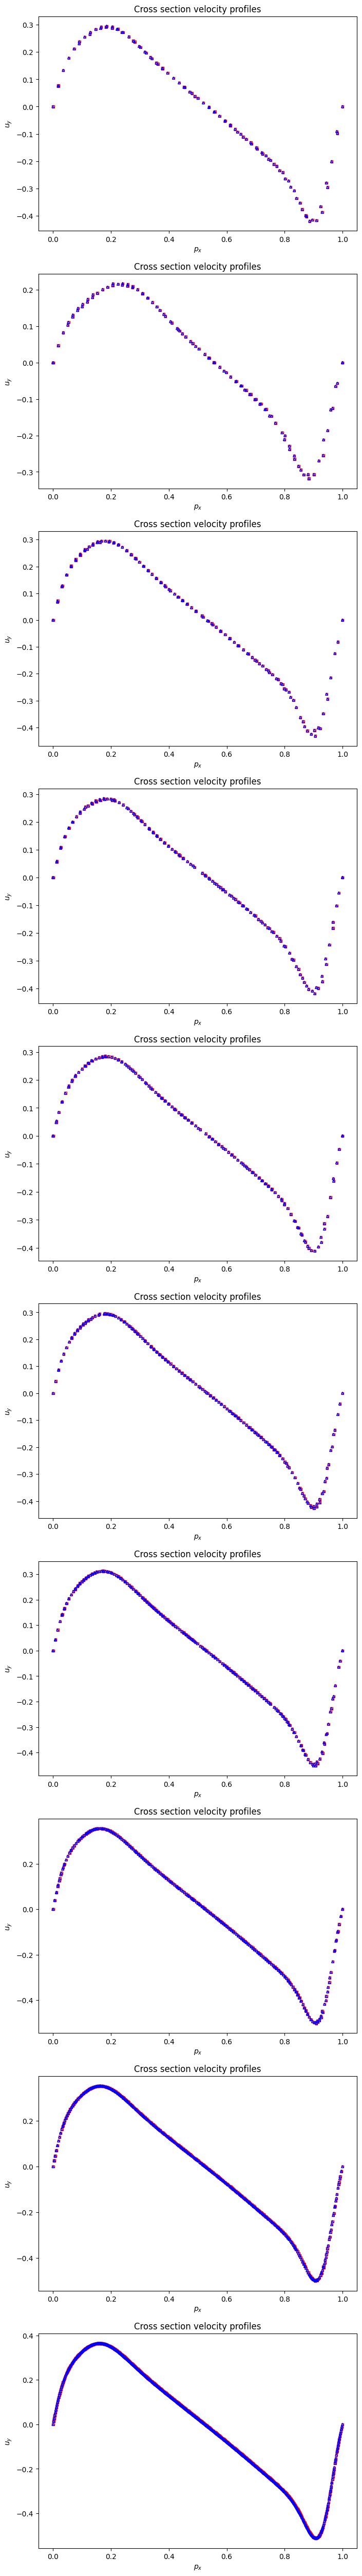

In [83]:
fig, axs = plt.subplots(len(hs_acm), figsize=(8,64))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['s', '^', '+', 'D']
for i, h in enumerate(hs_acm):
    for j, (name, program) in enumerate(programs_acm.items()):
        result_file = Path('..') / get_output_path(program, h)
        with h5py.File(result_file) as f:
            u = np.array(f['velocity'], dtype=np.float64)
            pos = np.array(f['domain/pos'], dtype=np.float64)
            midplane_velocity_profile(axs[i], pos, u, h, markers[j], colors[j])